# without CPU speeding up

In [2]:
# Import required modules
import logging
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.SugarScape import SugarScape
from src.Agents.Cell import Cell
from src.Agents.Trader import Trader

def setup_logger():
    """Set up a logger for simulation."""
    logger = logging.getLogger("simulation")
    handler = logging.FileHandler("simulation.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def run_model(variable_parameters, map_scheme, seed_value):
    """Run the SugarScape model with given parameters and log the process."""
    logger = setup_logger()
    model = SugarScape(metabolism_mean=variable_parameters['metabolism_mean'], 
                       vision_mean=variable_parameters['vision'],
                       map_scheme=map_scheme,
                       seed_value=seed_value)
    for step in range(max_steps):
        model.step()
        if step % 10 == 0:  # Output every 10 steps
            logger.info(f"Model step {step}: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, map_scheme={map_scheme}")
    total_population = model.schedule.get_agent_count()
    gini_coefficient = model.datacollector.get_model_vars_dataframe()['Gini'].values[-1]
    logger.info(f"Finished: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, total_population={total_population}, gini_coefficient={gini_coefficient}")
    return variable_parameters['metabolism_mean'], variable_parameters['vision'], total_population, gini_coefficient

# Define variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[2, 8], [2, 13]]
}

# Set experiment parameters
replicates = 10  # Simplify debugging
max_steps = 500 # Increase steps
distinct_samples = 4  # Set as 2^n

# Generate parameter samples
param_values = saltelli.sample(problem, distinct_samples)
total_runs = replicates * len(param_values)

# Create parameter list
param_list = []
for i in range(replicates):
    for vals in param_values:
        # Convert parameter sample values to integers
        variable_parameters = {name: int(val) for name, val in zip(problem['names'], vals)}
        param_list.append(variable_parameters)

# Initialize data storage
data_uniform = pd.DataFrame(index=range(total_runs), columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])
data_random = pd.DataFrame(index=range(total_runs), columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])
data_clustered = pd.DataFrame(index=range(total_runs), columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])

# Run model in single process
map_schemes = ['split','uniform', 'top_heavy']
seed_value = None  # or None for different results each time

for map_scheme in map_schemes:
    results = []
    for params in tqdm(param_list, desc=f"Running for map_scheme={map_scheme}"):
        results.append(run_model(params, map_scheme, seed_value))

    # Save results
    data = pd.DataFrame(results, columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])
    data.to_csv(f'simulation_results_{map_scheme}.csv', index=False)

print("All experiments done!")



<ipython-input-2-040dc5e7d835>:51: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples)
Running for map_scheme=split:   0%|          | 0/240 [00:00<?, ?it/s]

Running for map_scheme=split:  15%|█▌        | 36/240 [2:04:00<5:05:45, 89.93s/it]  /opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: inva

KeyboardInterrupt: 

# with CPU speeding up
but not functioning well i think cuz the printing is stuck
i dont know why its stuck

In [2]:
# Import required modules
import logging
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.SugarScape import SugarScape
from src.Agents.Cell import Cell
from src.Agents.Trader import Trader
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count
import os

def setup_logger():
    """Set up a logger for simulation."""
    logger = logging.getLogger(f"worker_{os.getpid()}")
    handler = logging.FileHandler(f"worker_{os.getpid()}.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def run_model(params):
    """Run the SugarScape model with given parameters and log the process."""
    variable_parameters, map_scheme, seed_value = params
    logger = setup_logger()
    model = SugarScape(metabolism_mean=variable_parameters['metabolism_mean'], 
                       vision_mean=variable_parameters['vision'],
                       map_scheme=map_scheme,
                       seed_value=seed_value)
    for step in range(max_steps):
        model.step()
        if step % 10 == 0:  # Output every 10 steps
            logger.info(f"Model step {step}: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, map_scheme={map_scheme}")
    total_population = model.schedule.get_agent_count()
    gini_coefficient = model.datacollector.get_model_vars_dataframe()['Gini'].values[-1]
    logger.info(f"Finished: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, total_population={total_population}, gini_coefficient={gini_coefficient}")
    return variable_parameters['metabolism_mean'], variable_parameters['vision'], total_population, gini_coefficient, map_scheme

# Define variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[2, 8], [2, 13]]
}

# Set experiment parameters
replicates = 10  # Simplify debugging
max_steps = 500  # Increase steps
distinct_samples = 4  # Set as 2^n

# Generate parameter samples
param_values = saltelli.sample(problem, distinct_samples)
total_runs = replicates * len(param_values)

# Create parameter list
param_list = []
map_schemes = ['uniform', 'top_heavy', 'split']
seed_value = None  # or a fixed value for reproducibility

for map_scheme in map_schemes:
    for i in range(replicates):
        for vals in param_values:
            # Convert parameter sample values to integers
            variable_parameters = {name: int(val) for name, val in zip(problem['names'], vals)}
            param_list.append((variable_parameters, map_scheme, seed_value))

# Run model in parallel
if __name__ == "__main__":
    print("Starting parallel processing...")
    results = []
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        future_to_params = {executor.submit(run_model, params): params for params in param_list}
        for future in tqdm(as_completed(future_to_params), total=len(future_to_params), desc="Processing"):
            results.append(future.result())

    print("Parallel processing completed. Saving results...")
    # Save results
    for map_scheme in map_schemes:
        scheme_results = [result for result in results if result[4] == map_scheme]
        data = pd.DataFrame(scheme_results, columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient', 'map_scheme'])
        data.to_csv(f'simulation_results_{map_scheme}.csv', index=False)

    print("All experiments done and results saved!")




Starting parallel processing...


<ipython-input-2-c1c730fecf83>:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples)
Processing:   0%|          | 0/720 [00:00<?, ?it/s]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

# Plotting

                       ST   ST_conf
metabolism_mean  1.228635  0.559977
vision           0.006019  0.231972
                       S1   S1_conf
metabolism_mean  0.518833  5.308470
vision           0.025026  3.068271
                                 S2   S2_conf
(metabolism_mean, vision)  1.497835  8.796396
                       ST   ST_conf
metabolism_mean  2.188020  1.341293
vision           0.206222  0.527504
                       S1   S1_conf
metabolism_mean  0.957911  0.488520
vision          -0.113240  0.233164
                                 S2   S2_conf
(metabolism_mean, vision)  1.922481  1.160977


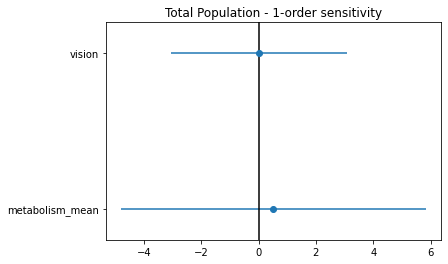

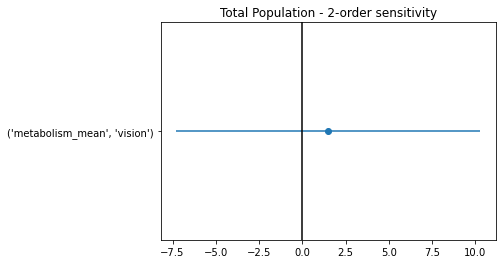

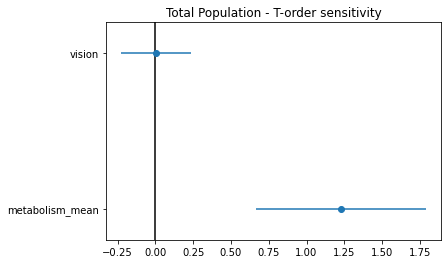

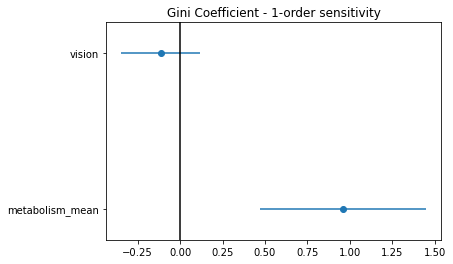

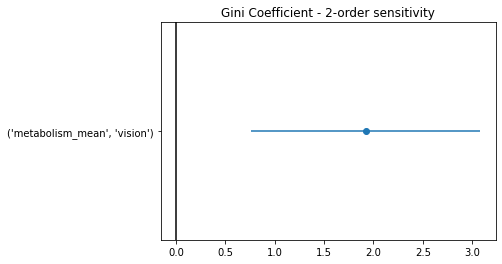

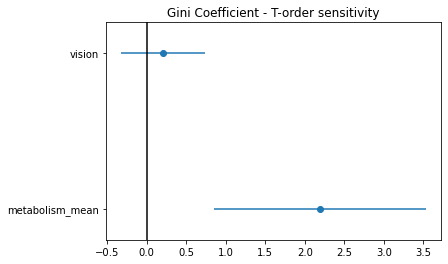

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from SALib.analyze import sobol
from itertools import combinations
import numpy as np

# Read experiment results
data = pd.read_csv('simulation_results.csv')

# Define variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[1, 10], [2, 12]]
}

# Perform Sobol sensitivity analysis
Si_population = sobol.analyze(problem, data['Total Population'].values, print_to_console=True)
Si_gini = sobol.analyze(problem, data['Gini Coefficient'].values, print_to_console=True)

# Visualization function for sensitivity indices
def plot_index(s, params, i, title=''):
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        # Filter indices to exclude NaN values
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        # Filter errors to exclude NaN values
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)
    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Plot sensitivity indices
for Si, output_name in [(Si_population, "Total Population"), (Si_gini, "Gini Coefficient")]:
    for i in ['1', '2', 'T']:
        plot_index(Si, problem['names'], i, f'{output_name} - {i}-order sensitivity')
        plt.show()

